## 重写创建客户分类

### 导入数据

In [1]:
# 检查python版本
from sys import version_info
if version_info.major != 2 and version_info.minor != 7:
    raise Exception('请使用Python 2.7来完成此项目')

In [2]:
# 导入数据
# 引入这个项目需要的库
import numpy as np
import pandas as pd
import visuals as vs
from IPython.display import display # 使得我们可以对DataFrame使用display()函数

# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline

# 载入整个客户数据集
try:
    data =pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"
    
display(data.head(5))

Wholesale customers dataset has 440 samples with 6 features each.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


### 分析数据

In [3]:
# 显示数据集的一个描述
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


#### 1.选择数据
为了对客户有一个更好的了解，并且了解代表他们的数据将会在这个分析过程中如何变换。最好是选择几个样本数据点，并且更为详细地分析它们。在下面的代码单元中，选择**三个**索引加入到索引列表`indices`中，这三个索引代表你要追踪的客户。我们建议你不断尝试，直到找到三个明显不同的客户。

In [4]:
# TODO：从数据集中选择三个你希望抽样的数据点的索引
indices = [47, 75, 81]

# 为选择的样本建立一个DataFrame
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,44466,54259,55571,7782,24171,6465
1,20398,1137,3,4407,3,975
2,219,9540,14403,283,7818,156


#### 2.特征相关性

一个有趣的想法是，考虑这六个类别中的一个（或者多个）产品类别，是否对于理解客户的购买行为具有实际的相关性。也就是说，当用户购买了一定数量的某一类产品，我们是否能够确定他们必然会成比例地购买另一种类的产品。有一个简单的方法可以检测相关性：我们用移除了某一个特征之后的数据集来构建一个监督学习（回归）模型，然后用这个模型去预测那个被移除的特征，再对这个预测结果进行评分，看看预测结果如何。

在下面的代码单元中，你需要实现以下的功能：
 - 使用`DataFrame.drop`函数移除数据集中你选择的不需要的特征，并将移除后的结果赋值给`new_data`。
 - 使用`sklearn.model_selection.train_test_split`将数据集分割成训练集和测试集。
   - 使用移除的特征作为你的目标标签。设置`test_size`为`0.25`并设置一个`random_state`。
 - 导入一个DecisionTreeRegressor（决策树回归器），设置一个`random_state`，然后用训练集训练它。
 - 使用回归器的`score`函数输出模型在测试集上的预测得分。

In [14]:
new_data = data.drop('Detergents_Paper', axis = 1)
labels = data['Detergents_Paper']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, labels, test_size = 0.25, random_state=0)

from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(random_state=0)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print score

0.728655181254


分析：
决定系数（coefficient of determination）, R^2,结果在0到1之间，1表示完美拟合，一个负的R^2表示模型不能够拟合数据。尝试预测所有特征，发现清洁纸品（Detergents_Paper）特征得分最高，为0.729； 这个结果比较接近1，说明模型拟合数据效果比较好，即清洁纸品可以由其他五个特征预测得出，也就是它对区分用户消费习惯来说没有必要。

#### 3.可视化特征分布
为了能够对这个数据集有一个更好的理解，我们可以对数据集中的每一个产品特征构建一个散布矩阵（scatter matrix）。如果你发现你在上面尝试预测的特征对于区分一个特定的用户来说是必须的，那么这个特征和其它的特征可能不会在下面的散射矩阵中显示任何关系。相反的，如果你认为这个特征对于识别一个特定的客户是没有作用的，那么通过散布矩阵可以看出在这个数据特征和其它特征中有关联性。运行下面的代码以创建一个散布矩阵。

结果：存在特征彼此之间存在一定程度相关性，比如milk,detergents_paper与grocery三者之间，两两都存在相关性； 这个结果验证了之前预测的特征，即detergents_paper与其他特征具有相关性； 这些特征的数据不符合正态分布，大多数数据点分布在75%所对应的值附近

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


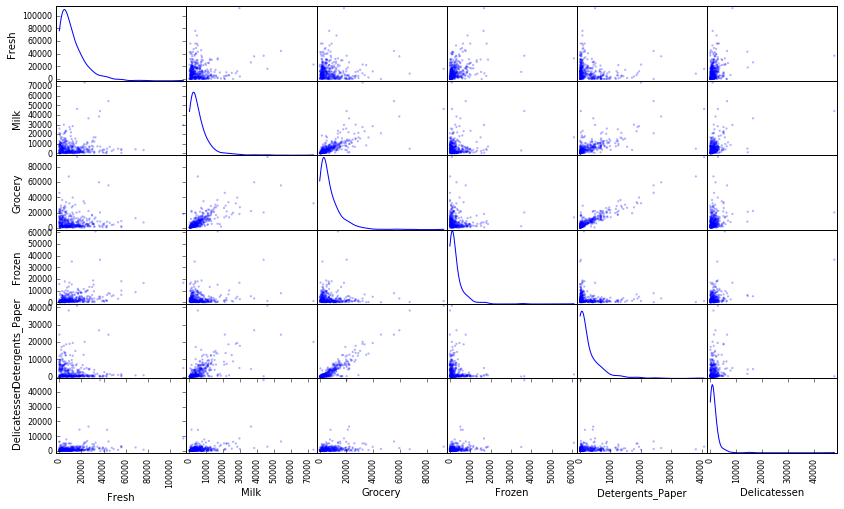

In [15]:
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
display(data.corr())#皮尔逊相关系数来进行量化

### 数据预处理

#### 1.特征缩放（偏斜处理）
如果数据不是正态分布的，尤其是数据的平均数和中位数相差很大的时候（表示数据非常歪斜）。这时候通常用一个非线性的缩放是很合适的，（英文原文） — 尤其是对于金融数据。一种实现这个缩放的方法是使用Box-Cox 变换，这个方法能够计算出能够最佳减小数据倾斜的指数变换方法。一个比较简单的并且在大多数情况下都适用的方法是使用自然对数。

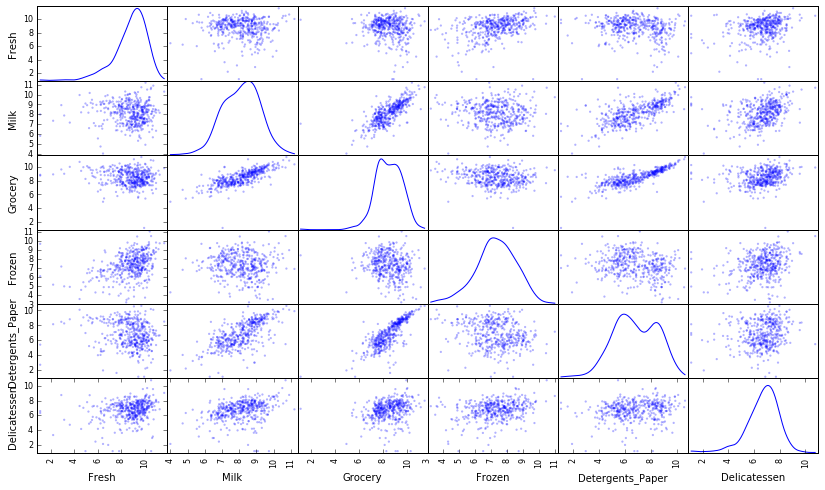

In [18]:
# TODO：使用自然对数缩放数据
log_data = np.log(data)
#还可以写为：log_data = data.apply(lambda x: np.log(x))

# TODO：使用自然对数缩放样本数据
log_samples = np.log(samples)

# 为每一对新产生的特征制作一个散射矩阵
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [19]:
# 展示经过对数变换后的样本数据
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.702480,10.901524,10.925417,8.959569,10.092909,8.774158
1,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
2,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856


#### 2.异常值检测
对于任何的分析，在数据预处理的过程中检测数据中的异常值都是非常重要的一步。异常值的出现会使得把这些值考虑进去后结果出现倾斜。这里有很多关于怎样定义什么是数据集中的异常值的经验法则。这里我们将使用Tukey的定义异常值的方法：一个异常阶（outlier step）被定义成1.5倍的四分位距（interquartile range，IQR）。一个数据点如果某个特征包含在该特征的IQR之外的特征，那么该数据点被认定为异常点。

在下面的代码单元中，你需要完成下面的功能：

    将指定特征的25th分位点的值分配给Q1。使用np.percentile来完成这个功能。
    将指定特征的75th分位点的值分配给Q3。同样的，使用np.percentile来完成这个功能。
    将指定特征的异常阶的计算结果赋值给step.
    选择性地通过将索引添加到outliers列表中，以移除异常值。

注意： 如果你选择移除异常值，请保证你选择的样本点不在这些移除的点当中！ 一旦你完成了这些功能，数据集将存储在good_data中。
多于一个特征下被认为是异常点的有65，66，75，128，154； 这些点应该被移除，因为它们在大于一个特征中被认为是异常，说明它们存在问题的可能性较大，为了不影响后续整个特征的处理，应该将它们移除。

In [23]:
# 对于每一个特征，找到值异常高或者是异常低的数据点
outliers = []
tukey_count = np.zeros(data.shape[0]) # 初始化一个 mask

for feature in log_data.keys():
    
    # TODO：计算给定特征的Q1（数据的25th分位点）
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO：计算给定特征的Q3（数据的75th分位点）
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO：使用四分位范围计算异常阶（1.5倍的四分位距）
    step = 1.5*(Q3-Q1)
    
    tukey = ~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))  # 符合 tukey 的布尔列
    tukey_count += tukey.astype(int)
    # 显示异常点
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])

# 收集 outliers
outliers = np.where(tukey_count > 1)[0]
print outliers
# 可选：选择你希望移除的数据点的索引
outliers  = [65, 66, 75, 128, 154]

# 如果选择了的话，移除异常点
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
#print len(good_data)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


[ 65  66  75 128 154]


#### 3. PCA
在good_data上使用PCA算法以发现数据的哪一个维度能够最大化特征的方差
某一特定维度上的正向增长对应**正权**特征的**增长**和**负权**特征的**减少**。增长和减少的速率和每个特征的权重相关。

[ 0.44302505  0.26379218  0.1230638   0.10120908  0.04850196  0.02040793]


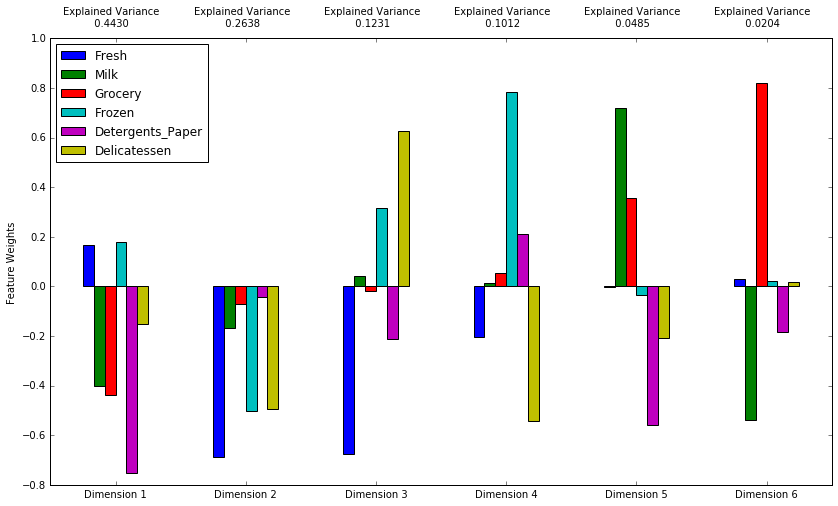

In [26]:
# TODO：通过在good_data上使用PCA，将其转换成和当前特征数一样多的维度
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(good_data)
print pca.explained_variance_ratio_

# TODO：使用上面的PCA拟合将变换施加在log_samples上
pca_samples = pca.transform(log_samples) 
#print pca.explained_variance_ratio_

# 生成PCA的结果图
pca_results = vs.pca_results(good_data, pca)

分析：
第一主成分最能代表咖啡馆类消费客户，因为fresh,frozen和delicatessen正向增长，符合咖啡馆的消费特点； 第二主成份最能代表零售商的消费，因为milk,grocery,detergents_paper特征在正向增长，对应消费水平较高，符合零售商的特点； 第三主成份最能代表超市类的客户，因为除fresh之外，其他都在增向增长，符合超市多样化需求的特点； 第四主成份最能代表超市类客户，因为除delicatessen外，其他都在正向增长，符合超市多样化需求的特点

#### 降维
当使用主成分分析的时候，一个主要的目的是减少数据的维度，这实际上降低了问题的复杂度。当然降维也是需要一定代价的：更少的维度能够表示的数据中的总方差更少。因为这个，累计解释方差比（cumulative explained variance ratio）对于我们确定这个问题需要多少维度非常重要。另外，如果大部分的方差都能够通过两个或者是三个维度进行表示的话，降维之后的数据能够被可视化。

在下面的代码单元中，你将实现下面的功能：

    将good_data用两个维度的PCA进行拟合，并将结果存储到pca中去。
    使用pca.transform将good_data进行转换，并将结果存储在reduced_data中。
    使用pca.transform将log_samples进行转换，并将结果存储在pca_samples中。

In [29]:
pca = PCA(n_components = 2)
pca.fit(good_data)

reduced_data = pca.transform(good_data)
pca_samples = pca.transform(log_samples)

# 为降维后的数据创建一个DataFrame
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# 展示经过两个维度的PCA转换之后的样本log-data
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-4.3646,-3.9519
1,8.3026,-0.4747
2,-3.1493,3.6261


#### 可视化双标图
双标图是一个散点图，每个数据点的位置由它所在主成分的分数确定。坐标系是主成分（这里是Dimension 1 和 Dimension 2）。此外，双标图还展示出初始特征在主成分上的投影。一个双标图可以帮助我们理解降维后的数据，发现主成分和初始特征之间的关系。

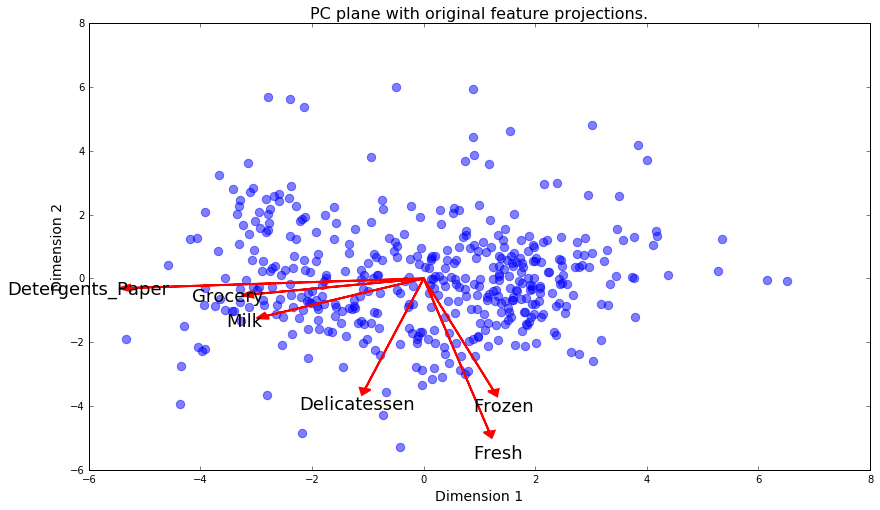

In [30]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### 聚类

#### 1.创建聚类
针对不同情况，有些问题你需要的聚类数目可能是已知的。但是在聚类数目不作为一个先验知道的情况下，我们并不能够保证某个聚类的数目对这个数据是最优的，因为我们对于数据的结构（如果存在的话）是不清楚的。但是，我们可以通过计算每一个簇中点的轮廓系数来衡量聚类的质量。数据点的轮廓系数衡量了它与分配给他的簇的相似度，这个值范围在-1（不相似）到1（相似）。平均轮廓系数为我们提供了一种简单地度量聚类质量的方法。

在接下来的代码单元中，你将实现下列功能：

    在reduced_data上使用一个聚类算法，并将结果赋值到clusterer，需要设置 random_state 使得结果可以复现。
    使用clusterer.predict预测reduced_data中的每一个点的簇，并将结果赋值到preds。
    使用算法的某个属性值找到聚类中心，并将它们赋值到centers。
    预测pca_samples中的每一个样本点的类别并将结果赋值到sample_preds。
    导入sklearn.metrics.silhouette_score包并计算reduced_data相对于preds的轮廓系数。
        将轮廓系数赋值给score并输出结果。

In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
clusterer = GaussianMixture(n_components = 2, random_state = 0)
clusterer.fit(reduced_data)
# TODO：预测每一个点的簇
preds = clusterer.predict(reduced_data)

# TODO：找到聚类中心
centers = clusterer.means_
#print centers
# TODO：预测在每一个转换后的样本点的类
sample_preds = clusterer.predict(pca_samples)

# TODO：计算选择的类别的平均轮廓系数（mean silhouette coefficient）
score = silhouette_score(reduced_data, preds)
print score

0.421916846463


分析：
我尝试了2，3，4,5,6,7,8,9,10,50,100 2时轮廓系数为0.42 3时轮廓系数为0.37， 4时轮廓系数为0.32， 5时轮廓系数为0.30 6时轮廓系数为0.22 7时轮廓系数为0.27 8时轮廓系数为0.34 9时轮廓系数为0.33 10时轮廓系数为0.34 50时轮廓系数为0.29 100时轮廓系数为0.32 聚类数为2时能达到最佳轮廓系数

#### 2.聚类可视化

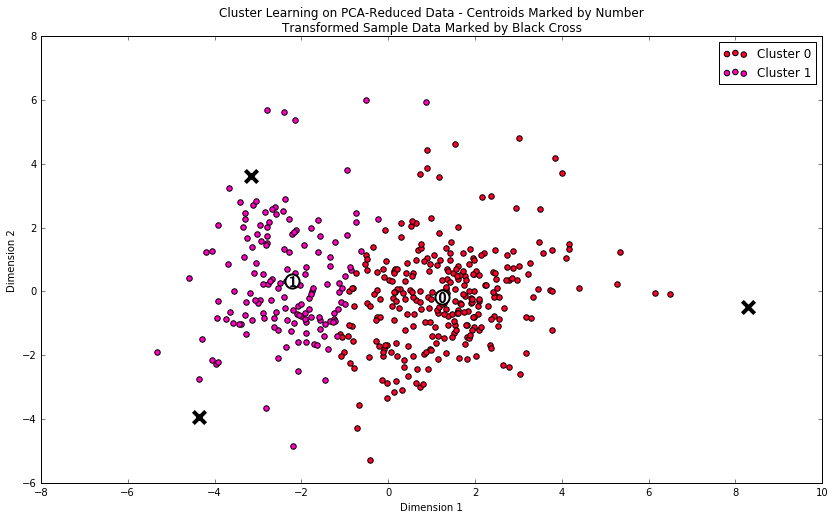

In [38]:
# 从已有的实现中展示聚类的结果
vs.cluster_results(reduced_data, preds, centers, pca_samples)

#### 3.数据恢复
上面的可视化图像中提供的每一个聚类都有一个中心点。这些中心（或者叫平均点）并不是数据中真实存在的点，但是是所有预测在这个簇中的数据点的平均。对于创建客户分类的问题，一个簇的中心对应于那个分类的平均用户。因为这个数据现在进行了降维并缩放到一定的范围，我们可以通过施加一个反向的转换恢复这个点所代表的用户的花费。

在下面的代码单元中，你将实现下列的功能：

    使用pca.inverse_transform将centers 反向转换，并将结果存储在log_centers中。
    使用np.log的反函数np.exp反向转换log_centers并将结果存储到true_centers中。

In [39]:
log_centers = pca.inverse_transform(centers)
true_centers = np.exp(log_centers)

# 显示真实的中心点
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8953.0,2114.0,2765.0,2075.0,353.0,732.0
Segment 1,3552.0,7837.0,12219.0,870.0,4696.0,962.0


理解：我的理解反向转换中心点就是将中心点所代表的用户花费求出来，相当于计算出这个均值对应的用户，这个用户不是真实存在的，但是可以作为参考，从而确定这个类到底是什么用户

我认为Segment0代表超市或者零售商客户，因为它的6个特征值和总体数据50%的数据比较接近，处于大多数客户消费的水平，不同类产品的消费比较均匀； Segment1代表咖啡馆类客户，因为它的grocrery和detergents_paper与总体均值相比明显偏低，fresh,milk相对总体均值比较高，符合咖啡馆的特点

#### 4.预测样本所属的类别

In [40]:
# 显示预测结果
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1
